In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp
import seaborn as sns
plt.style.use('seaborn-v0_8-poster')

## Implementación de NARMA10 y MSO12

In [2]:
def narma10(n=100):
    y = np.random.rand(n + 10)
    u = np.random.uniform(0, 0.5, n + 10)

    for t in range(10, n + 10 - 1):
        y[t+1] = 0.3 * y[t] + \
               0.05 * y[t] * np.sum(y[t - 10 : t]) + \
               1.5 * u[t - 9] * u[t] + \
               0.1
    return y[10 : n + 10]

# https://www.sciencedirect.com/science/article/pii/S0925231221013333#b0210
def mso12(n=100):
    t = np.arange(n)
    frequencies = [0.2, 0.331, 0.42, 0.51, 0.63, 0.74, 0.85, 0.97, 1.08, 1.19, 1.27, 1.32]
    y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))

    return y


## Implementación de MG17 con RK4

In [3]:
def dydt(t, y, y_hat, a, b, n):
    return (a * y_hat)/(1 + y_hat**n) + b * y

def solve_MG_System_RK4(a, b, n, tau, t_start, t_end, num_points):
    h = (t_end - t_start) / num_points
    t_values = np.linspace(t_start, t_end, num_points)
    y_values = np.zeros(num_points)

    # Initialize randomly after tau time steps
    y_values[:tau] = np.random.random(tau)

    for i in range(tau, num_points):
        t = t_values[i]
        y_hat = y_values[i - tau]
        y = y_values[i - 1]

        k1 = h * dydt(t, y, y_hat, a, b, n)
        k2 = h * dydt(t + 0.5 * h, y + 0.5 * k1, y_hat, a, b, n)
        k3 = h * dydt(t + 0.5 * h, y + 0.5 * k2, y_hat, a, b, n)
        k4 = h * dydt(t + h, y + k3, y_hat, a, b, n)

        y_values[i] = y + (1/6) * (k1 + 2*k2 + 2*k3 + k4)

    return t_values, y_values

def MGSystem(N=1000):
    # Parameters
    a = 0.2
    b = -0.1
    n = 10
    tau = 17
    t_start = 0
    t_end = N  # Define the upper limit of the time range
    num_points = N

    # Solve the differential equation
    t_values, y_values = solve_MG_System_RK4(a, b, n, tau, t_start, t_end, num_points)

    return y_values


## Funciones para el Algoritmo Adaptativo sad-RC

In [4]:
def make_invertible(matrix, epsilon=1e-6):
    # Add small random perturbations to the diagonal elements
    perturbed_matrix = matrix + epsilon * np.random.randn(*matrix.shape)

    # Ensure the perturbed matrix is invertible
    while np.linalg.matrix_rank(perturbed_matrix) < matrix.shape[0]:
        perturbed_matrix = matrix + epsilon * np.random.randn(*matrix.shape)

    return perturbed_matrix

def generate_K_matrix(n, rho, sparsity=0.95, rho_threshold=1e-5):
    # generate a random matrix with desired sparsity and range of values
    M = np.random.uniform(-1, 1, (n, n))
    
    flattened_matrix = M.flatten()
    # Calculate the number of elements to set as zero
    num_elements = len(flattened_matrix)
    num_zero_elements = int(sparsity * num_elements)
    # Randomly select indices to set as zero
    zero_indices = np.random.choice(num_elements, num_zero_elements, replace=False)
    # Set the selected indices as zero in the flattened matrix
    flattened_matrix[zero_indices] = 0
    # Reshape the flattened matrix back to the original shape
    M = flattened_matrix.reshape(M.shape)

    return M

def rescale_spectral_radius(M, rho, rho_threshold=1e-5):
    # compute the current spectral radius of M
    eigvals = np.linalg.eigvals(M)
    current_rho = np.max(np.abs(eigvals))
    # ensure that current_rho is not zero
    if current_rho < rho_threshold:
        M = make_invertible(M)
        eigvals = np.linalg.eigvals(M)
        current_rho = np.max(np.abs(eigvals))

    # scale M to achieve the desired spectral radius
    M = M * (rho / current_rho)

    return M

def generate_W_matrix(n):
    # set the random seed for reproducibility
    #np.random.seed(42)

    # generate an array of 100 numbers with mean=0 and std=1
    W = np.random.randn(n)

    return W

def univariate_ridge_regression(theta, y, alpha=1e-2):
    # compute the weight matrix using ridge regression
    X = np.reshape(theta, (1, -1))
    Y = np.array([[y]])
    I = np.identity(X.shape[1])
    try:
        W_out = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y
    except np.linalg.LinAlgError:
        # if the matrix is singular, increase alpha and try again
        alpha *= 10
        try:
            W_out = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y
        except np.linalg.LinAlgError:
            alpha *= 10
            W_out = np.linalg.inv(X.T @ X + alpha * I) @ X.T @ Y

    return W_out

def kuramoto_synchrony(phases):
    N = len(phases)
    R = np.mean(np.exp(1j * phases))
    r = np.abs(R)
    return r

def MSE(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

def memory_capacity(y, k=100):
    s = np.random.uniform(-0.5, 0.5, size=len(y))
    s_shifted = np.roll(s, -k)  # Shift s(t) by k positions

    cov = np.cov(s_shifted, y)[0, 1]  # Calculate covariance between s(t-k) and y(t)
    var_s = np.var(s)  # Calculate variance of s(t)
    var_y = np.var(y)  # Calculate variance of y(t)

    memory_capacity = cov ** 2 / (var_s * var_y)
    return memory_capacity

## Gráficas de ejemplo de las series de tiempo implementadas

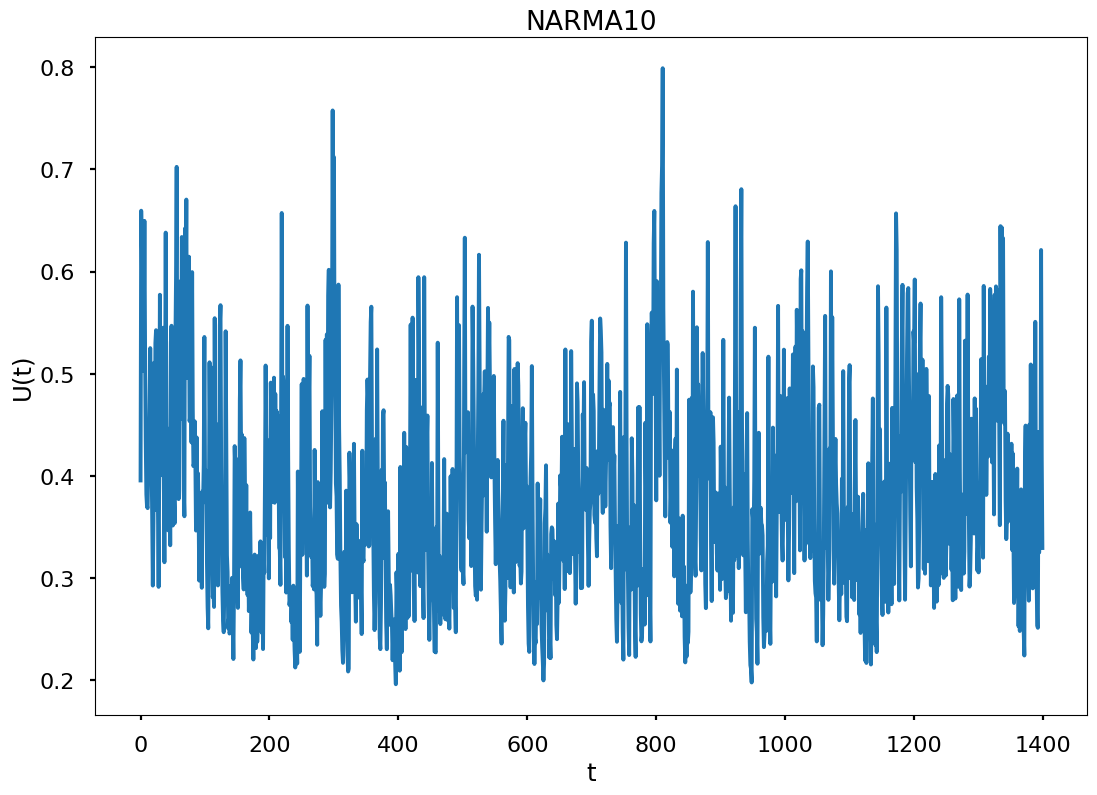

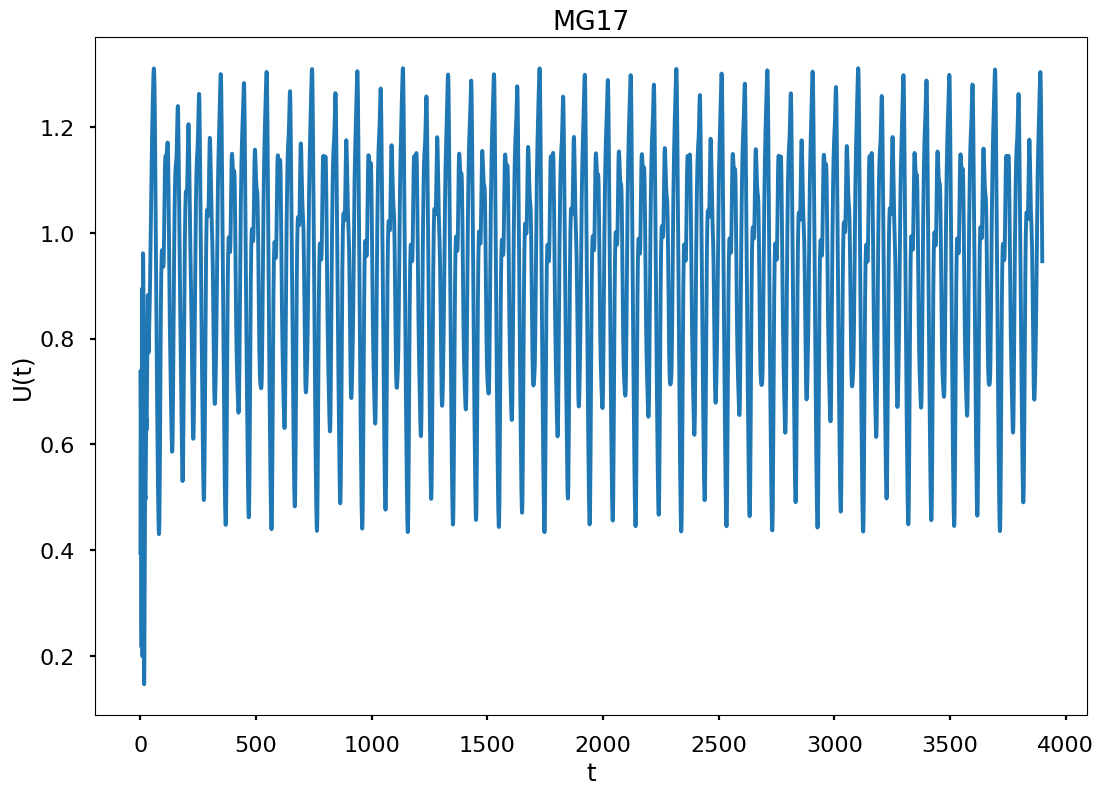

<ipython-input-2-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


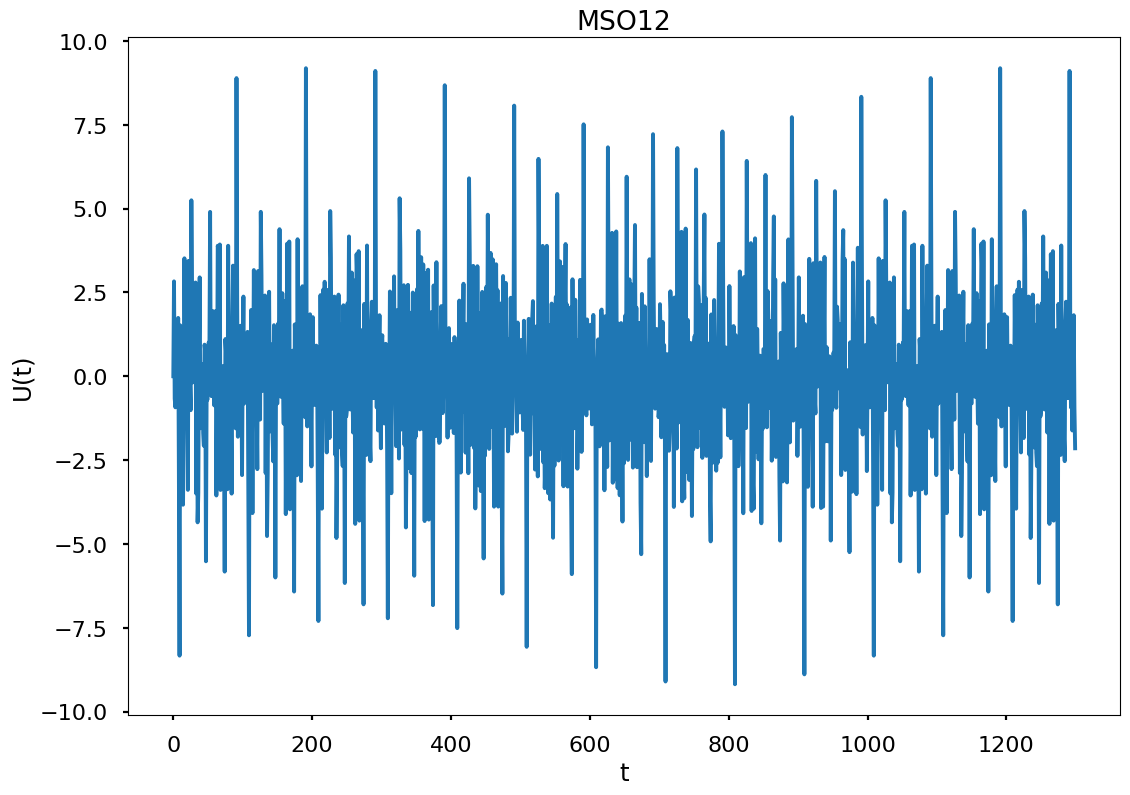

In [5]:
n = 1400
U = narma10(n)

plt.plot(range(n), U)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('NARMA10')
plt.show()

n = 3900
U = MGSystem(n)

plt.plot(range(n), U)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('MG17')
plt.show()

n = 1300
U = mso12(n)

plt.plot(range(n), U)
plt.xlabel('t')
plt.ylabel('U(t)')
plt.title('MSO12')
plt.show()

## Más Funciones para el Algoritmo Adaptativo sad-RC

In [12]:
h = 1.0
eps = 0.1

def f(t, THETA, W, L, K, u):
    result = []
    for i in range(N):
        val = W[i] + L * sum(K[i][j] * np.sin(THETA[j] - THETA[i] + u) for j in range(N))
        result.append(val)
    return np.array(result)

def bound(x):
    if x > 1:
        return 1
    if x < -1:
        return -1
    return x

def bound_matrix(M):
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            M[i, j] = bound(M[i, j])
    return M

def g(t, theta, i, j, B):
    Kij = -eps * np.sin(theta[j] - theta[i] + B)
    return Kij

def Euler_iteration(t, W, L, THETA, K, u):
    THETA[:, t] = THETA[:, t-1] + h * f(t-1, THETA[:, t-1], W, L, K, u)
    return THETA

def Euler_matrix_iteration(t, K, THETA, B):
    for i in range(N):
        for j in range(N):
            K[i][j] = K[i][j] + h * g(t, THETA[:, t], i, j, B)
    K = bound_matrix(K)
    return K

def train(U, K, rho, THETA, W, L, a, b, B):
    for t, u in zip(range(1, b + 1), U[1:b + 1]):
        THETA = Euler_iteration(t, W, L, THETA, K, u)
        if t <= a:
            K = Euler_matrix_iteration(t, K, THETA, B)
            K = rescale_spectral_radius(K, rho)
    W_out = univariate_ridge_regression(THETA[:, b], U[b])
    Y = []
    for t, u in zip(range(b + 1, n), U[b + 1:n]):
        THETA = Euler_iteration(t, W, L, THETA, K, u)
        y = W_out.T @ THETA[:, t] 
        Y.append(y[0])
        W_out = univariate_ridge_regression(THETA[:, t], U[t])

    return Y, THETA, K


## Experimento con parámetros fijos para NARMA10

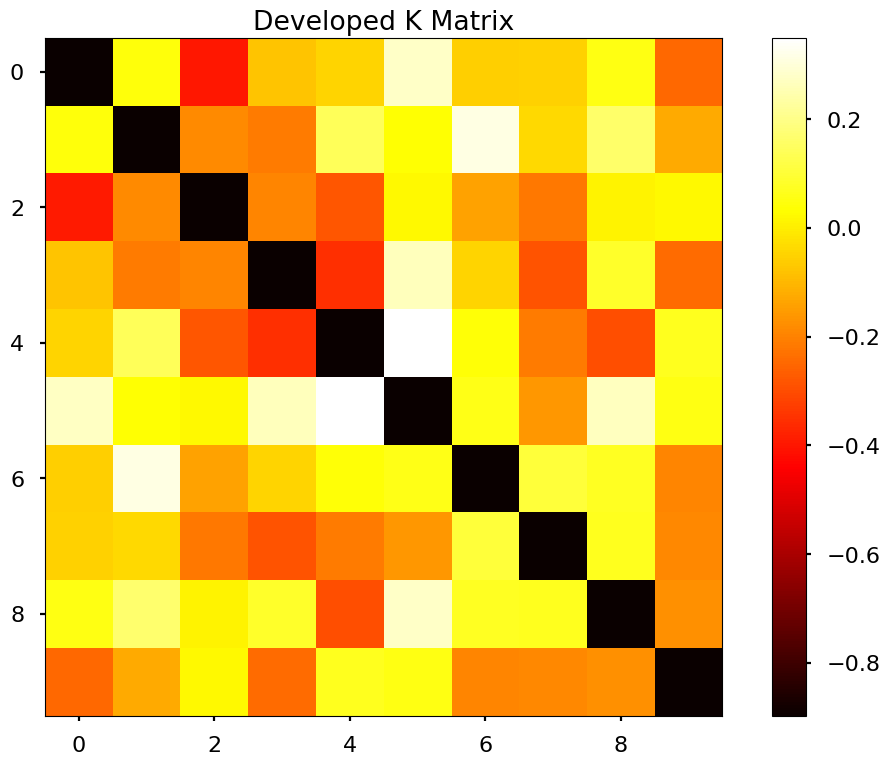

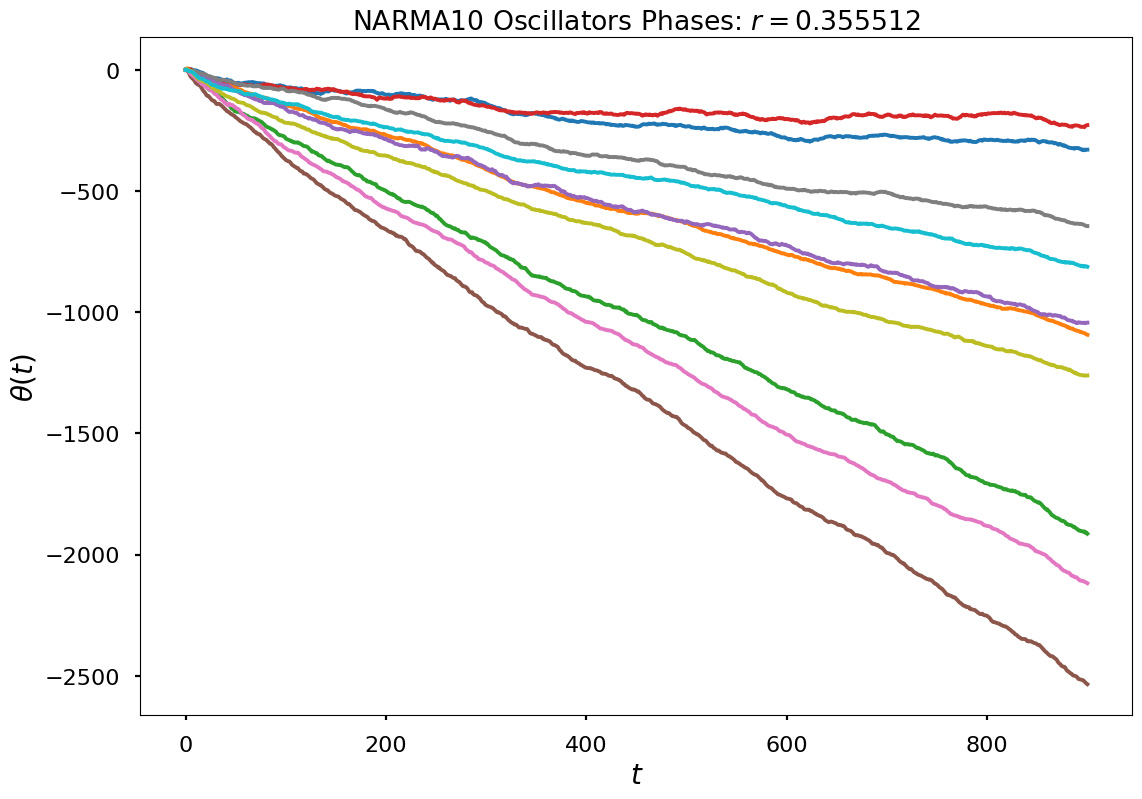

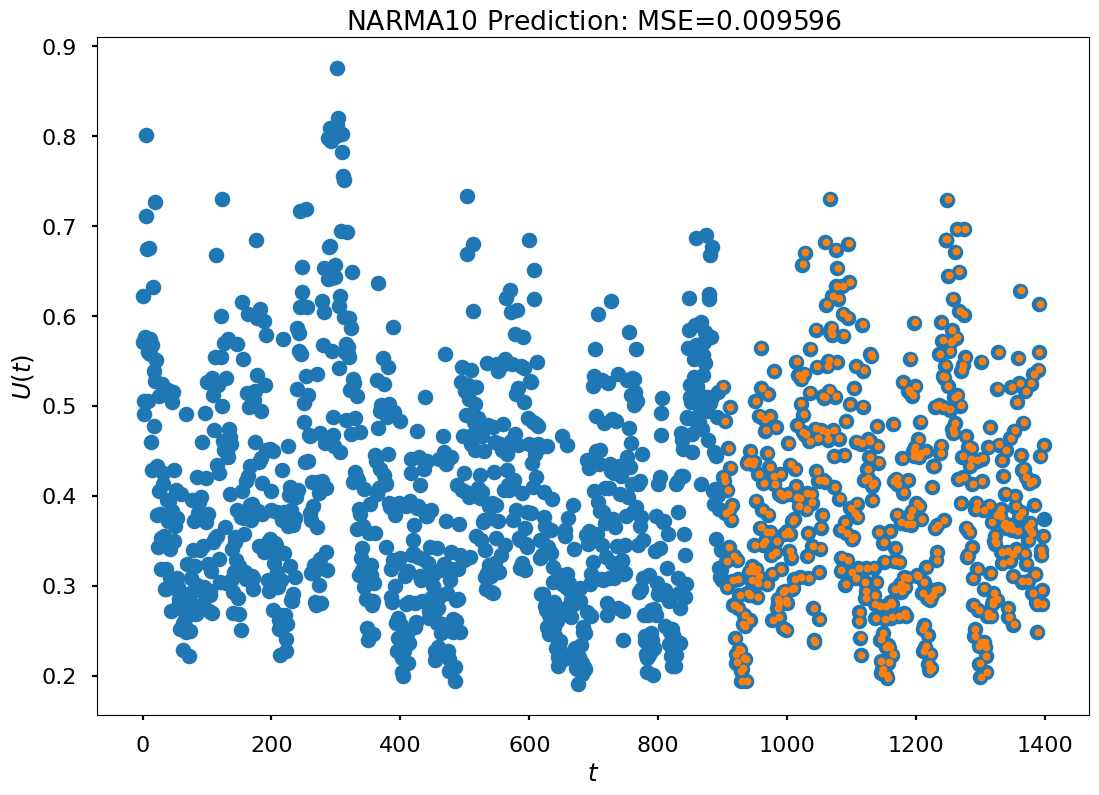

MSE: 0.009596322707529739
Synchrony: 0.35551200908089403


In [13]:
n = 1400
U = narma10(n)
a = 100
b = 900
N = 10
rho = 2.0
sparsity = 0.95 # density is 0.05
K = generate_K_matrix(N, rho, sparsity)
W = generate_W_matrix(N)
B = np.pi / 2
L = 4.0

THETA = np.zeros((N, n))
Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Developed K Matrix')
plt.show()

'''
plt.imshow(THETA[:, :50], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Oscillators Phases Heatmap')
plt.show()
'''

r = kuramoto_synchrony(THETA[:, -1])
mse = MSE(U[b + 1:], Y)

for i in range(N):
    plt.plot(range(b + 1), THETA[i, :b + 1], '-')
plt.xlabel(r'$t$', size=20)
plt.ylabel(r'$\theta(t)$', size=20)
plt.title(f'NARMA10 Oscillators Phases: $r={r:.6f}$')
plt.show()

plt.plot(np.array(range(n)), U, 'o')
plt.plot(np.array(range(b + 1, n)), np.array(Y), '.')
plt.xlabel('$t$')
plt.ylabel('$U(t)$')
plt.title(f'NARMA10 Prediction: MSE=${mse:.6f}$')
plt.show()

print('MSE:', mse)
print('Synchrony:', r)


## Experimento con parámetros fijos para MG17

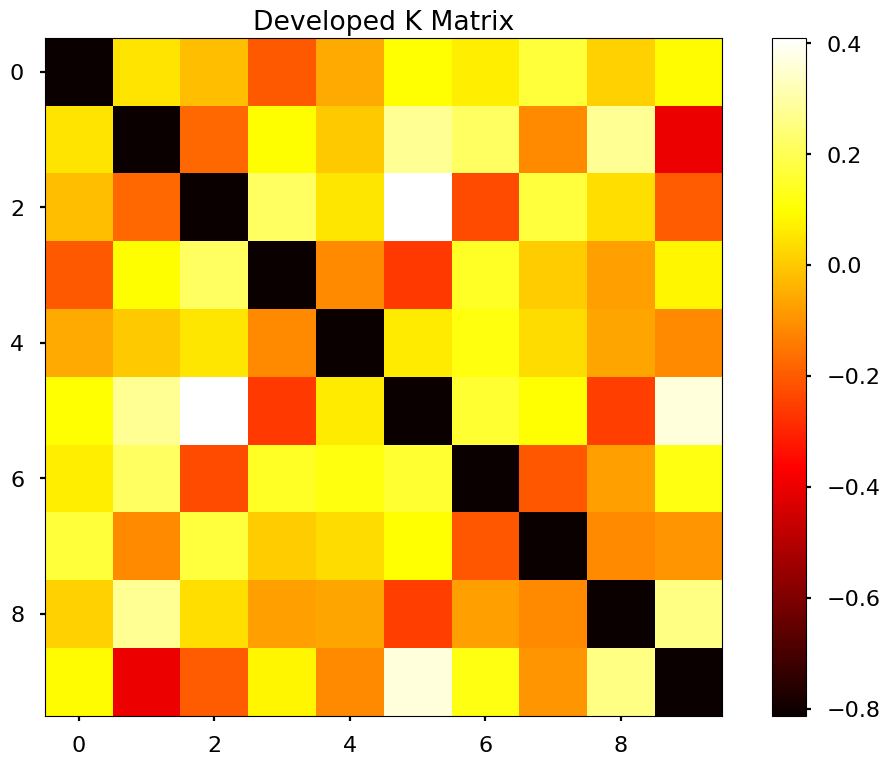

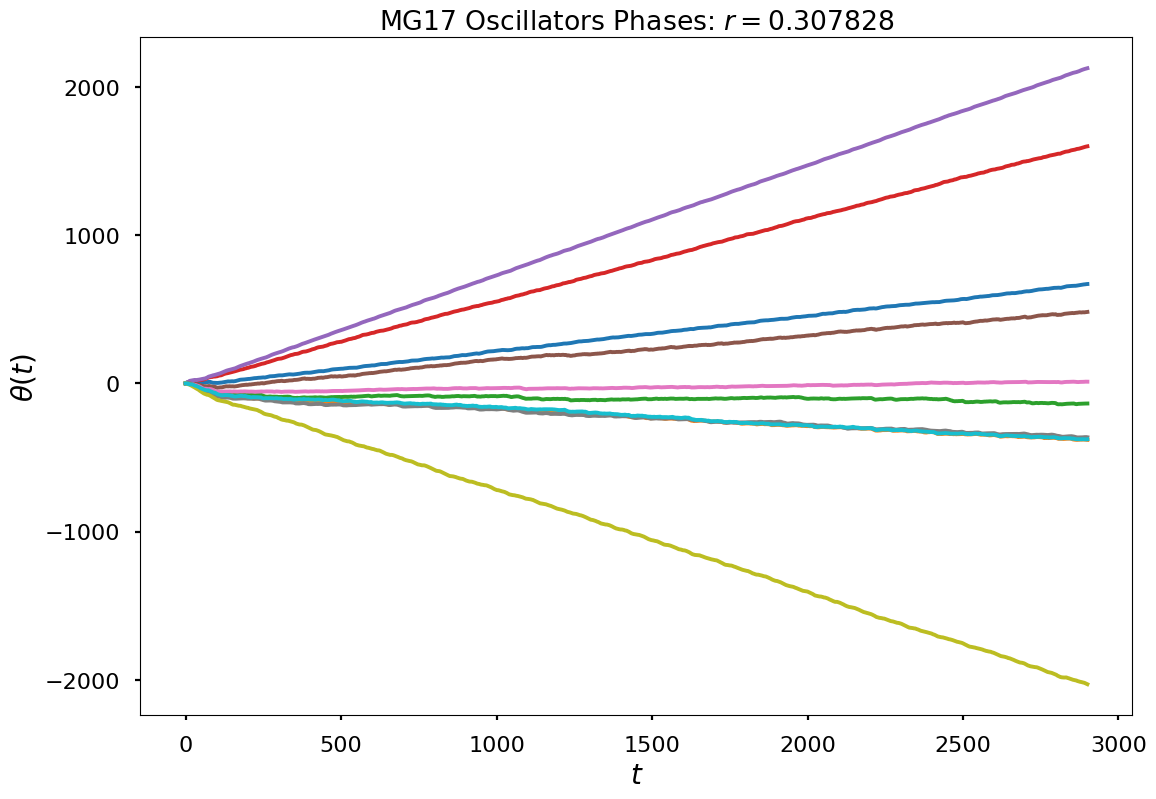

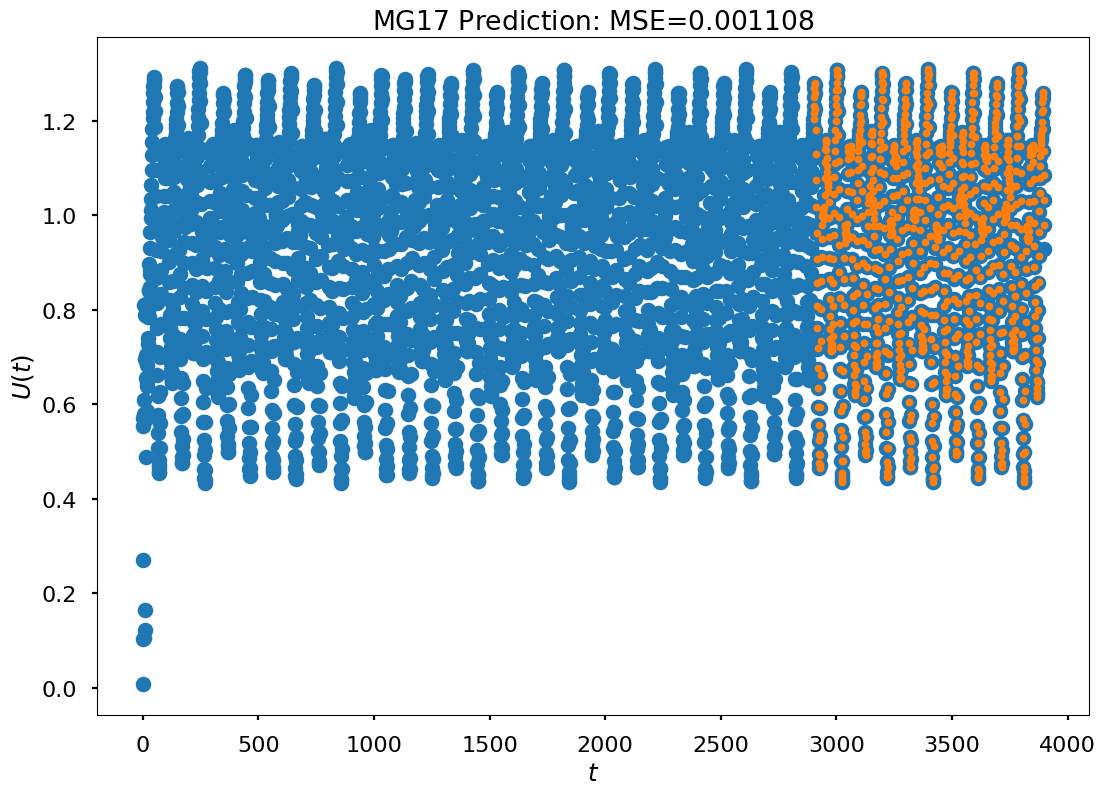

MSE: 0.0011077852378529292
Synchrony: 0.3078283733947383


In [14]:
n = 3900
U = MGSystem(n)
a = 100
b = 2900
N = 10
rho = 2.0
sparsity = 0.95 # density is 0.05
K = generate_K_matrix(N, rho, sparsity)
W = generate_W_matrix(N)
B = np.pi / 2
L = 1.0

THETA = np.zeros((N, n))
Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Developed K Matrix')
plt.show()

r = kuramoto_synchrony(THETA[:, -1])
mse = MSE(U[b + 1:], Y)

for i in range(N):
    plt.plot(range(b + 1), THETA[i, :b + 1], '-')
plt.xlabel(r'$t$', size=20)
plt.ylabel(r'$\theta(t)$', size=20)
plt.title(f'MG17 Oscillators Phases: $r={r:.6f}$')
plt.show()

plt.plot(np.array(range(n)), U, 'o')
plt.plot(np.array(range(b + 1, n)), np.array(Y), '.')
plt.xlabel('$t$')
plt.ylabel('$U(t)$')
plt.title(f'MG17 Prediction: MSE=${mse:.6f}$')
plt.show()

print('MSE:', mse)
print('Synchrony:', r)


## Experimento con parámetros fijos para MSO12

<ipython-input-2-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


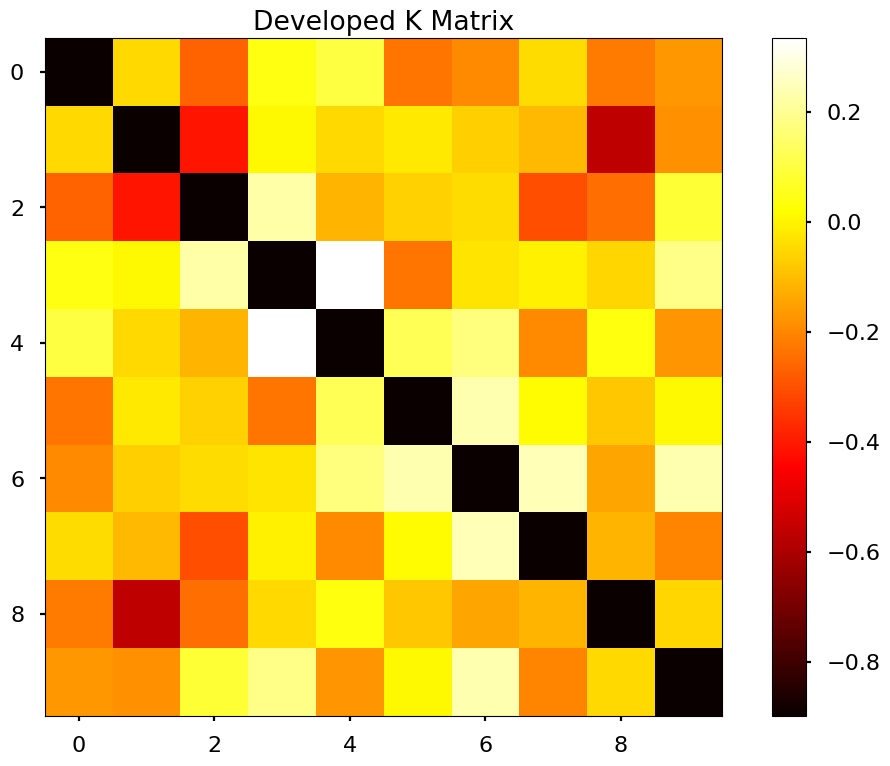

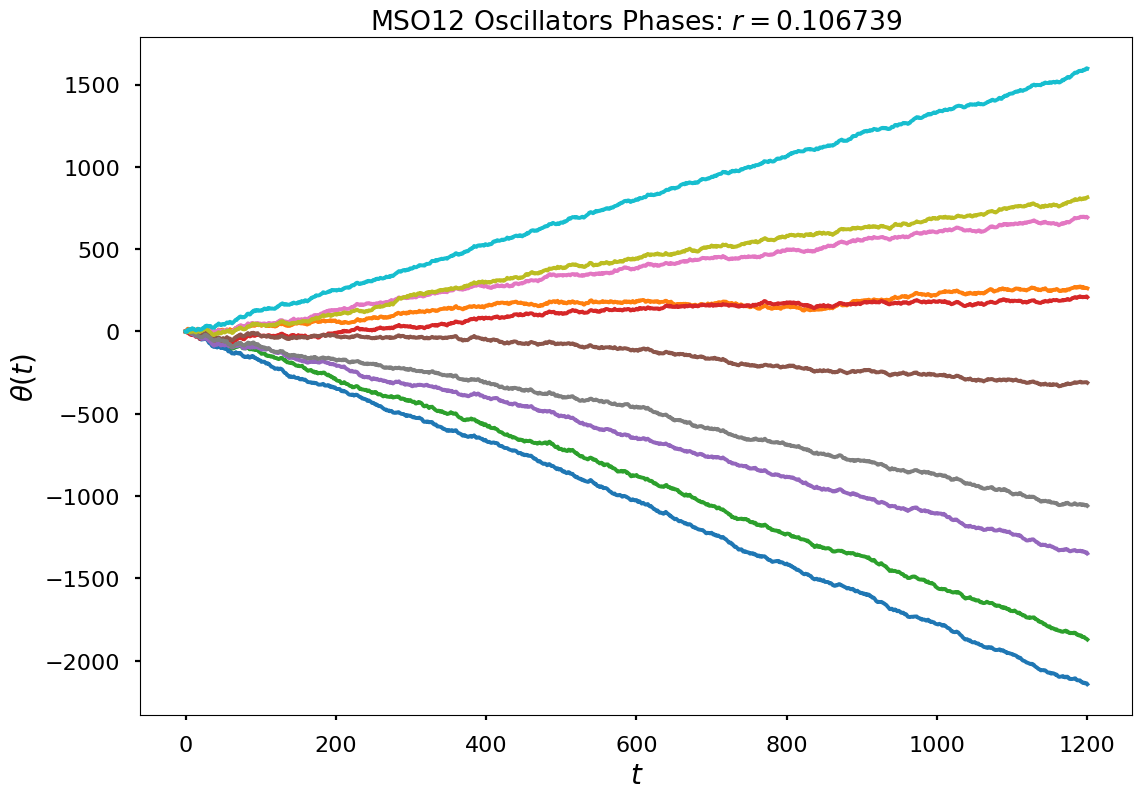

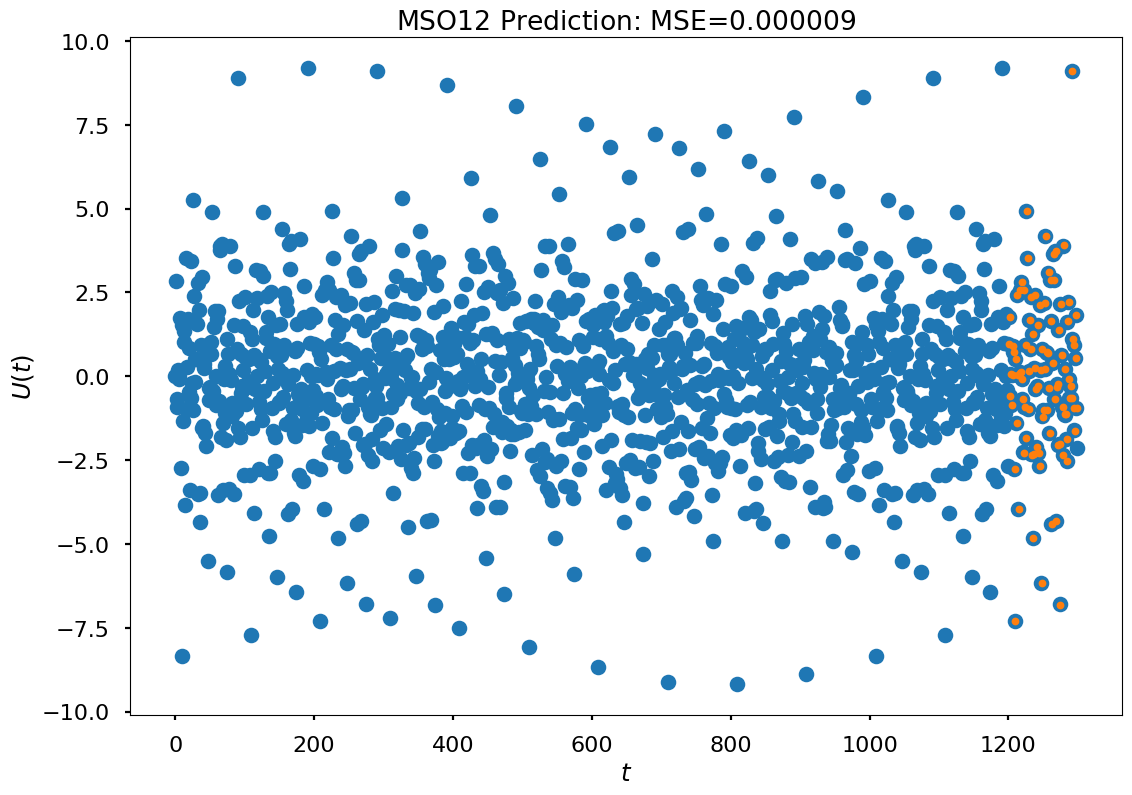

MSE: 8.990347844500225e-06
Synchrony: 0.10673899115006104


In [15]:
n = 1300
U = mso12(n)
a = 100
b = 1200
N = 10
rho = 2.0
sparsity = 0.95 # density is 0.05
K = generate_K_matrix(N, rho, sparsity)
W = generate_W_matrix(N)
B = np.pi / 2
L = 4.0

THETA = np.zeros((N, n))
Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

plt.imshow(K, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Developed K Matrix')
plt.show()

r = kuramoto_synchrony(THETA[:, -1])
mse = MSE(U[b + 1:-1], Y[1:])

for i in range(N):
    plt.plot(range(b + 1), THETA[i, :b + 1], '-')
plt.xlabel(r'$t$', size=20)
plt.ylabel(r'$\theta(t)$', size=20)
plt.title(f'MSO12 Oscillators Phases: $r={r:.6f}$')
plt.show()

plt.plot(np.array(range(n)), U, 'o')
plt.plot(np.array(range(b + 1, n)), np.array(Y), '.')
plt.xlabel('$t$')
plt.ylabel('$U(t)$')
plt.title(f'MSO12 Prediction: MSE=${mse:.6f}$')
plt.show()

print('MSE:', mse)
print('Synchrony:', r)


## Variación de radio espectral y fuerza de acoplamiento para NARMA10

0 0 0
MSE: 0.01116796577722349
r: 0.46360190670629625
0 1 0
MSE: 0.00943705590669088
r: 0.1616657955231112
0 2 0
MSE: 0.010358451605972572
r: 0.19094850410984898
0 3 0
MSE: 0.009995482131927642
r: 0.4269878139968636
0 4 0
MSE: 0.008864099766135933
r: 0.43256099693990635
0 5 0
MSE: 0.009350670306024983
r: 0.17467144892696965
0 6 0
MSE: 0.008881686259655975
r: 0.33199295786230515
0 7 0
MSE: 0.00905063019081046
r: 0.2787889769918939
0 8 0
MSE: 0.010308769630687564
r: 0.292165595842539
0 9 0
MSE: 0.009815478196792534
r: 0.05640263366505069
1 0 0
MSE: 0.009273524216831907
r: 0.32588915745571245
1 1 0
MSE: 0.009462121240889446
r: 0.18191336456314416
1 2 0
MSE: 0.009844007954737197
r: 0.5313623598119396
1 3 0
MSE: 0.008993775584312188
r: 0.307684651145576
1 4 0
MSE: 0.008178363113069683
r: 0.28722322207693296
1 5 0
MSE: 0.008465038612327521
r: 0.29792901010996264
1 6 0
MSE: 0.009196735201663407
r: 0.3692664341662008
1 7 0
MSE: 0.009857720014551001
r: 0.38894001555597973
1 8 0
MSE: 0.009580704

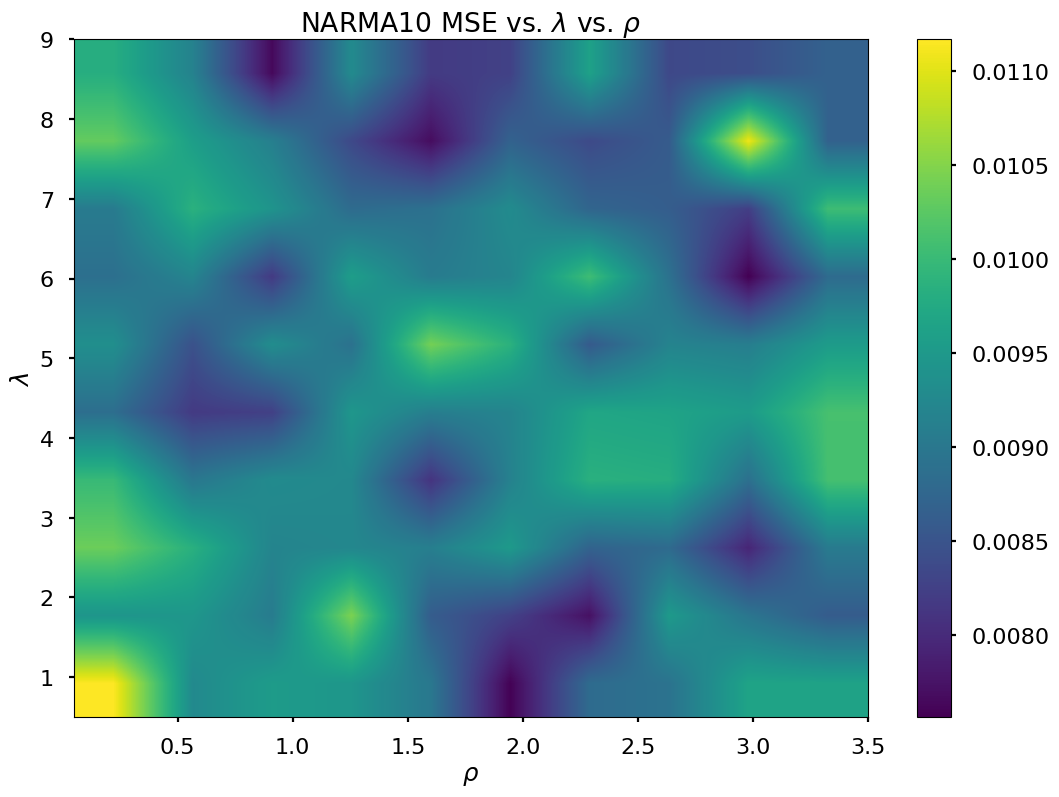

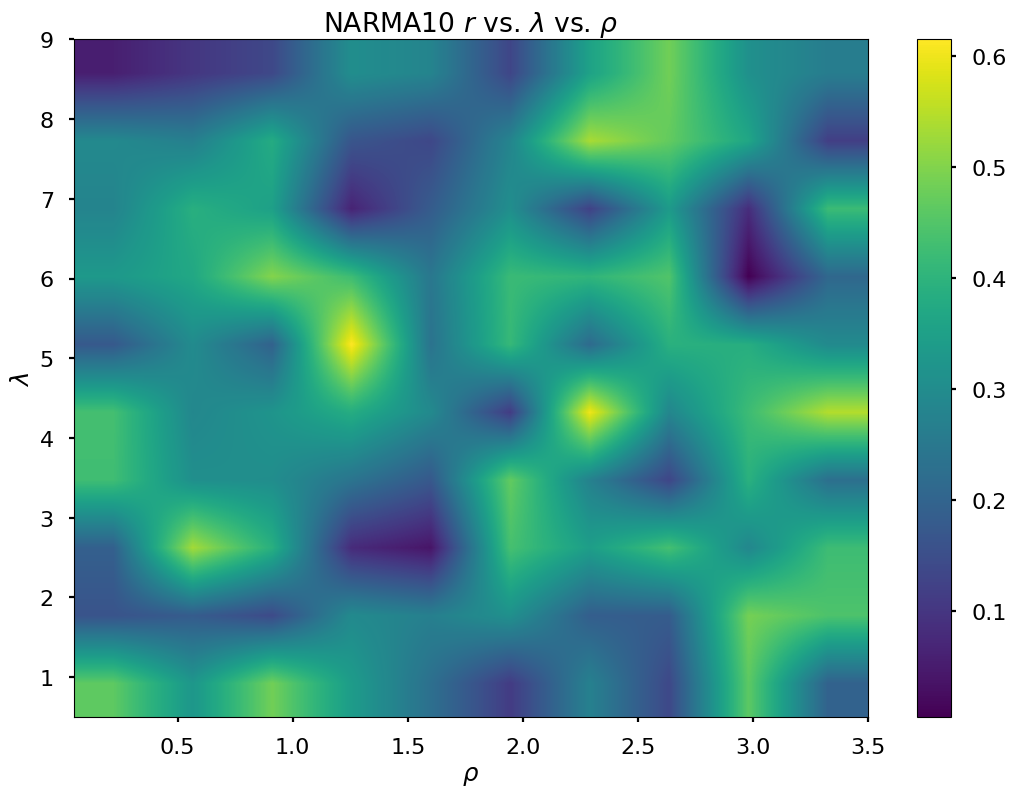

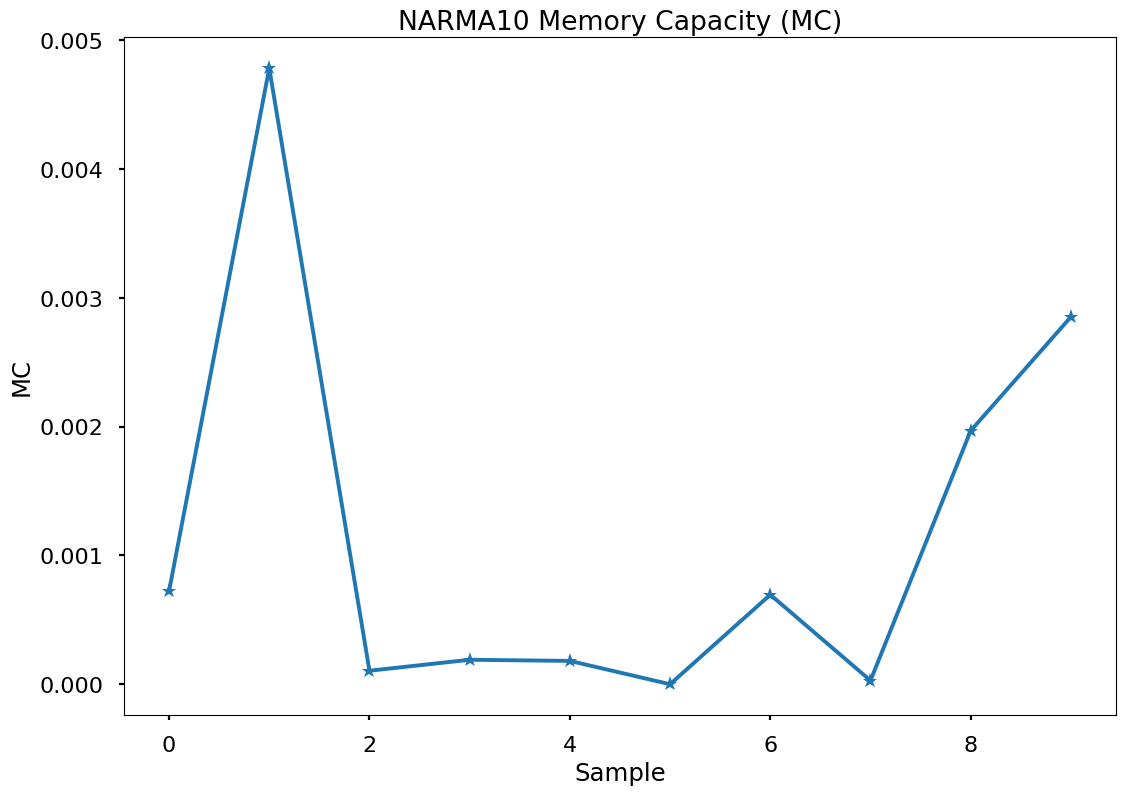

In [17]:
# Define the range of rho and L values to use
rhos = np.linspace(0.05, 3.5, 10)
Ls = np.linspace(0.5, 9, 10)

sparsity = 0.95

# Define the number of iterations to use
num_iterations = 1

# Initialize arrays to store the average MSE values
mse_values = np.zeros((len(rhos), len(Ls)))
r_values = np.zeros((len(rhos), len(Ls)))
mc_values = []

n = 1400
a = 100
b = 900

N = 10

sparsity = 0.05

# Loop over all combinations of rho and L values
for i, rho in enumerate(rhos):
    for j, L in enumerate(Ls):
        
        # Initialize the mean squared error to zero
        mse = 0
        r = 0
        
        # Perform multiple iterations and average the results
        for k in range(num_iterations):

            print(i, j, k)
            
            # Initialize the input sequence and network parameters
            U = narma10(n)
            K = generate_K_matrix(N, rho, sparsity)
            W = generate_W_matrix(N)
            THETA = np.zeros((N, n))
            
            # Train the network and compute the mean squared error
            Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
            mse += MSE(U[b + 1:], Y)
            r += kuramoto_synchrony(THETA[:, -1])
        
        mse /= num_iterations
        print('MSE:', mse)
        r /= num_iterations
        print('r:', r)

        # Store the mean squared error in the array
        mse_values[i, j] = mse
        r_values[i, j] = r
    
    mc = memory_capacity(Y)
    mc_values.append(mc)

# Create a contour plot of the average error as a function of rho and L
X, Y = np.meshgrid(rhos, Ls)
plt.imshow(mse_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'NARMA10 MSE vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

X, Y = np.meshgrid(rhos, Ls)
plt.imshow(r_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'NARMA10 $r$ vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

plt.plot(range(10), mc_values, '*-')
plt.xlabel('Sample')
plt.ylabel('MC')
plt.title('NARMA10 Memory Capacity (MC)')
plt.show()

## Variación de radio espectral y fuerza de acoplamiento para MG17

0 0 0
MSE: 0.0011102399943233923
r: 0.37514264302967243
0 1 0
MSE: 0.0010996432595273048
r: 0.048979835404942315
0 2 0
MSE: 0.0010967951960357142
r: 0.12622344264884194
0 3 0
MSE: 0.0010932786023342635
r: 0.19054864168376195
0 4 0
MSE: 0.0011121408222262057
r: 0.21860683332045394
0 5 0
MSE: 0.0010945936502077646
r: 0.5078088983383758
0 6 0
MSE: 0.0011096813509022553
r: 0.09306825276932912
0 7 0
MSE: 0.0011095306664727336
r: 0.396475762292526
0 8 0
MSE: 0.0011148305850844128
r: 0.294129054806382
0 9 0
MSE: 0.0011104120664850357
r: 0.5875677781046704
1 0 0
MSE: 0.0011221404280462926
r: 0.314640845247448
1 1 0
MSE: 0.0011108710188429236
r: 0.2891716896409425
1 2 0
MSE: 0.0010899570028442955
r: 0.25568230841923634
1 3 0
MSE: 0.0011225815962040584
r: 0.2681589827845872
1 4 0
MSE: 0.0010902283273724494
r: 0.5826708830387058
1 5 0
MSE: 0.001113941949194323
r: 0.44342523333385037
1 6 0
MSE: 0.0010949840426065218
r: 0.32261365814053605
1 7 0
MSE: 0.001100133535298067
r: 0.4117981407797892
1 8 0

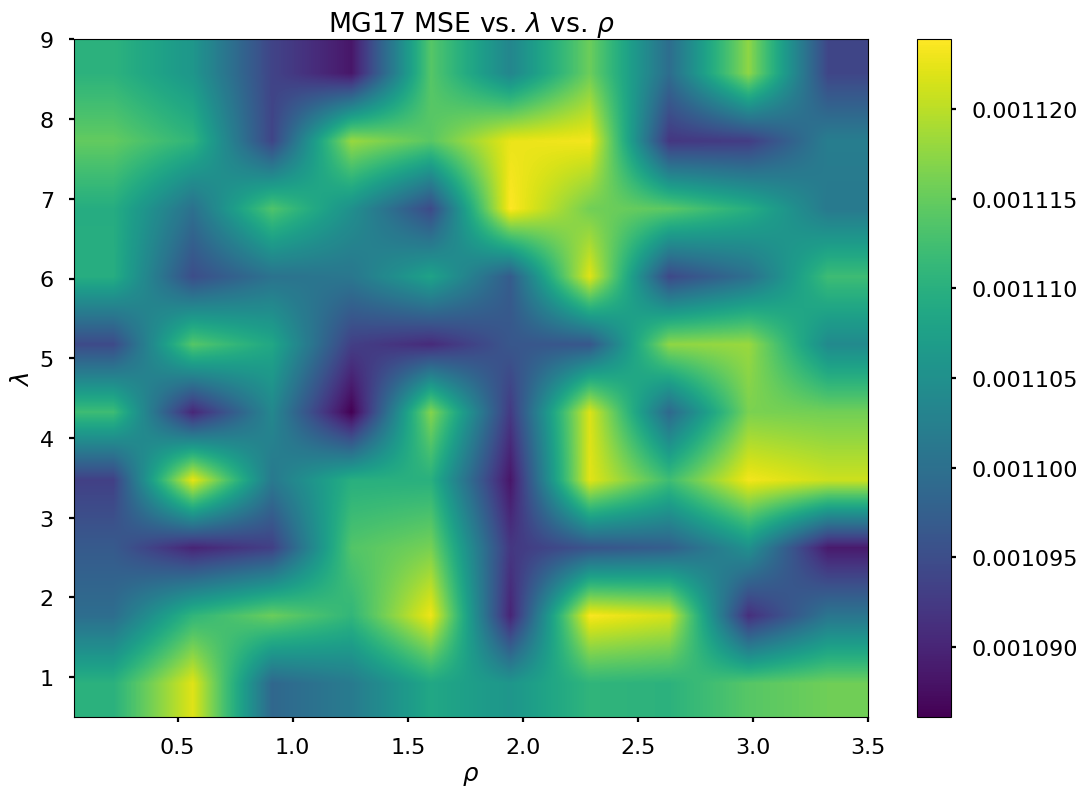

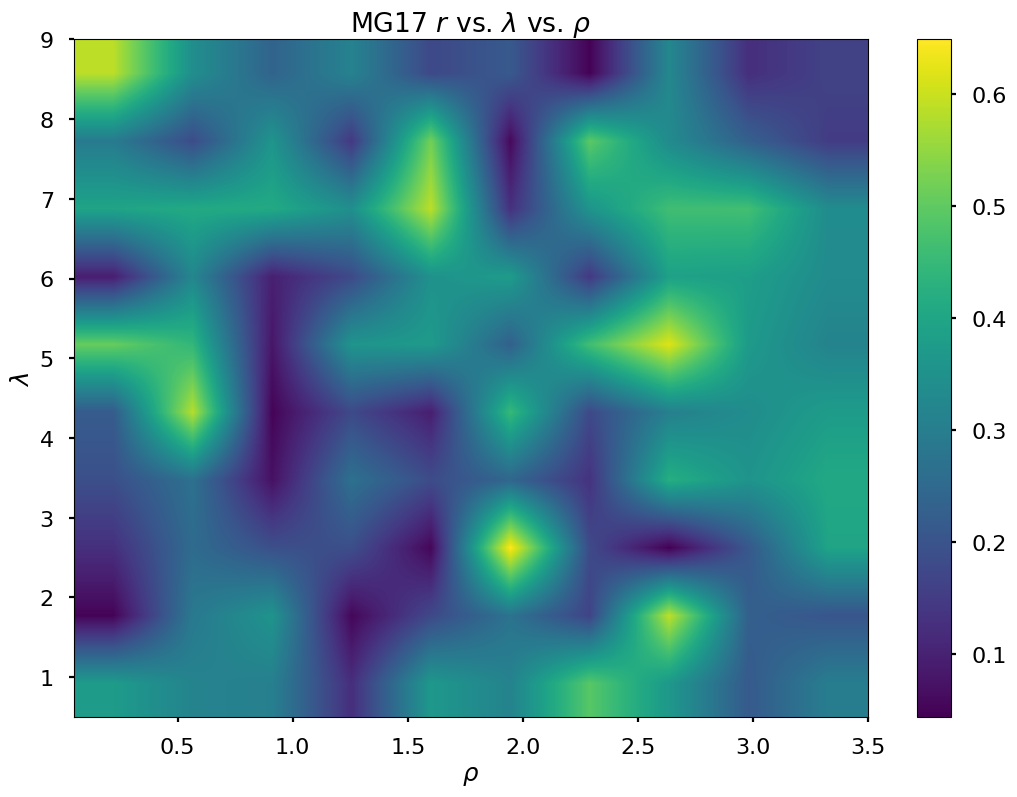

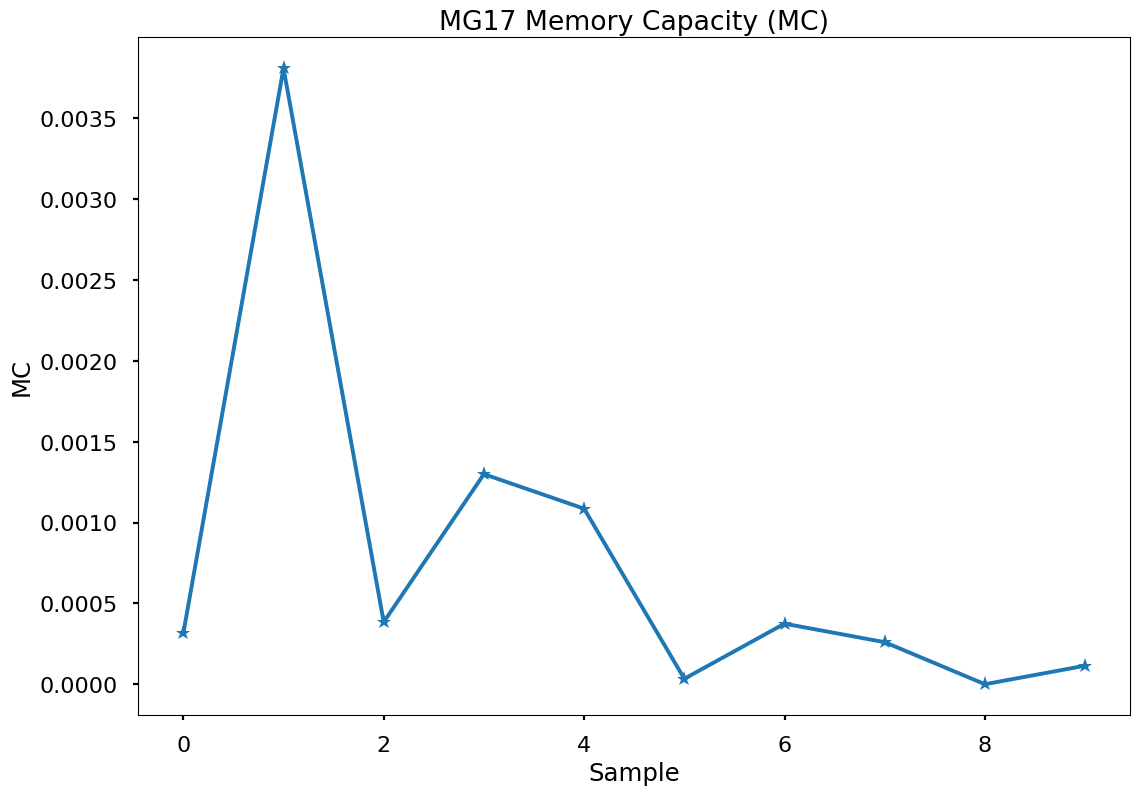

In [18]:
# Define the range of rho and L values to use
rhos = np.linspace(0.05, 3.5, 10)
Ls = np.linspace(0.5, 9, 10)

sparsity = 0.95

# Define the number of iterations to use
num_iterations = 1

# Initialize arrays to store the average MSE values
mse_values = np.zeros((len(rhos), len(Ls)))
r_values = np.zeros((len(rhos), len(Ls)))
mc_values = []

n = 3900
a = 100
b = 2900

N = 10

sparsity = 0.05

# Loop over all combinations of rho and L values
for i, rho in enumerate(rhos):
    for j, L in enumerate(Ls):
        
        # Initialize the mean squared error to zero
        mse = 0
        r = 0
        
        # Perform multiple iterations and average the results
        for k in range(num_iterations):

            print(i, j, k)
            
            # Initialize the input sequence and network parameters
            U = MGSystem(n)
            K = generate_K_matrix(N, rho, sparsity)
            W = generate_W_matrix(N)
            THETA = np.zeros((N, n))
            
            # Train the network and compute the mean squared error
            Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
            mse += MSE(U[b + 1:], Y)
            r += kuramoto_synchrony(THETA[:, -1])
        
        mse /= num_iterations
        print('MSE:', mse)
        r /= num_iterations
        print('r:', r)

        # Store the mean squared error in the array
        mse_values[i, j] = mse
        r_values[i, j] = r
    
    mc = memory_capacity(Y)
    mc_values.append(mc)

# Create a contour plot of the average error as a function of rho and L
X, Y = np.meshgrid(rhos, Ls)
plt.imshow(mse_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MG17 MSE vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

X, Y = np.meshgrid(rhos, Ls)
plt.imshow(r_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MG17 $r$ vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

plt.plot(range(10), mc_values, '*-')
plt.xlabel('Sample')
plt.ylabel('MC')
plt.title('MG17 Memory Capacity (MC)')
plt.show()

## Variación de radio espectral y fuerza de acoplamiento para MSO12

0 0 0


<ipython-input-2-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


MSE: 3.87747081312891e-06
r: 0.44960849360695726
0 1 0
MSE: 3.8786338720242705e-06
r: 0.11383054421383795
0 2 0
MSE: 3.866145236080328e-06
r: 0.3701015666498809
0 3 0
MSE: 3.8714314040902385e-06
r: 0.1304123079107021
0 4 0
MSE: 3.885563214373878e-06
r: 0.1621368188380461
0 5 0
MSE: 3.94883725180313e-06
r: 0.18590223508296733
0 6 0
MSE: 3.882478723596567e-06
r: 0.3574325614019926
0 7 0
MSE: 3.8457392870196175e-06
r: 0.44489573674514493
0 8 0
MSE: 3.844635380664081e-06
r: 0.18180432667278978
0 9 0
MSE: 3.847580869714313e-06
r: 0.24792424102372715
1 0 0
MSE: 3.859702264449502e-06
r: 0.14748035809183266
1 1 0
MSE: 3.9819908228899836e-06
r: 0.27285917076649174
1 2 0
MSE: 3.902673970386077e-06
r: 0.1921219977310177
1 3 0
MSE: 4.155031946676064e-06
r: 0.41354336517147944
1 4 0
MSE: 3.821327920459158e-06
r: 0.2214606886248577
1 5 0
MSE: 3.677044743870292e-06
r: 0.4828493534027672
1 6 0
MSE: 4.685726559354177e-06
r: 0.5264108162436921
1 7 0
MSE: 3.953993311348549e-06
r: 0.32582635520271375
1 8 

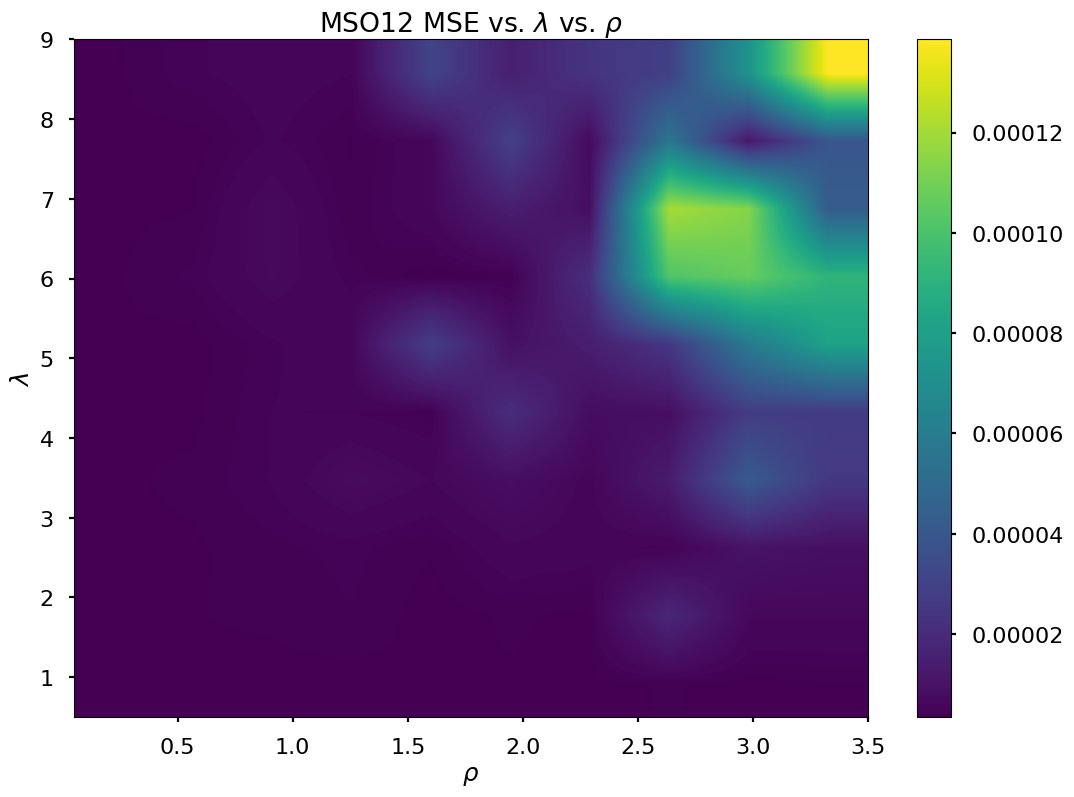

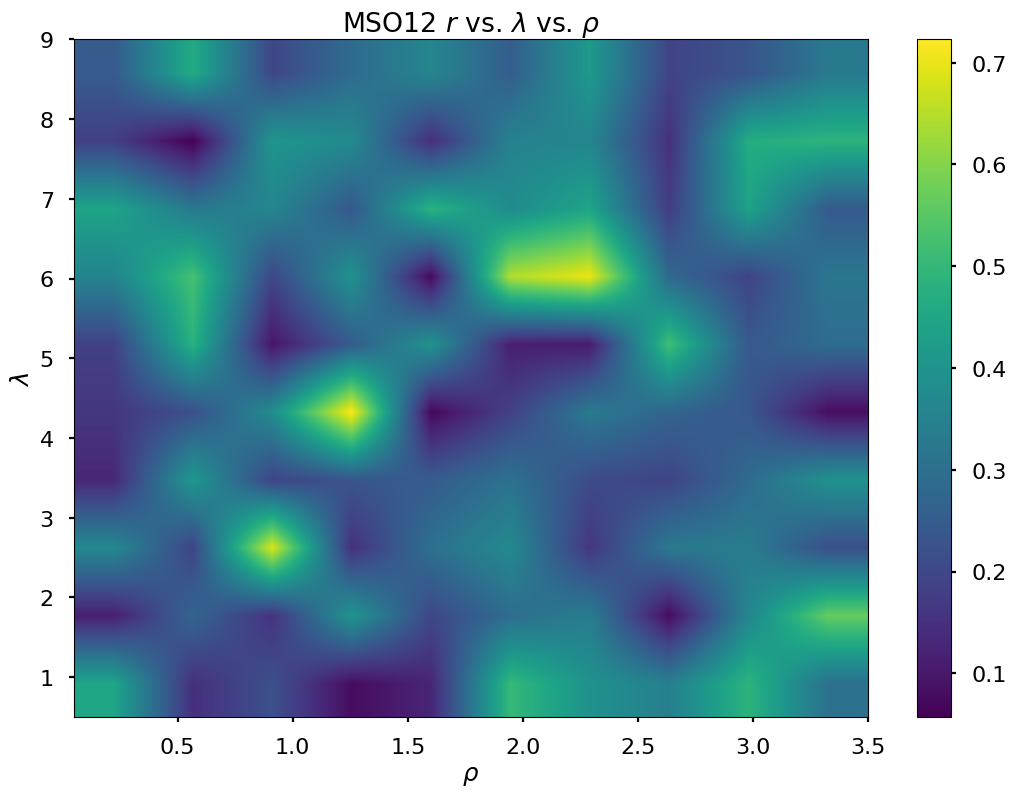

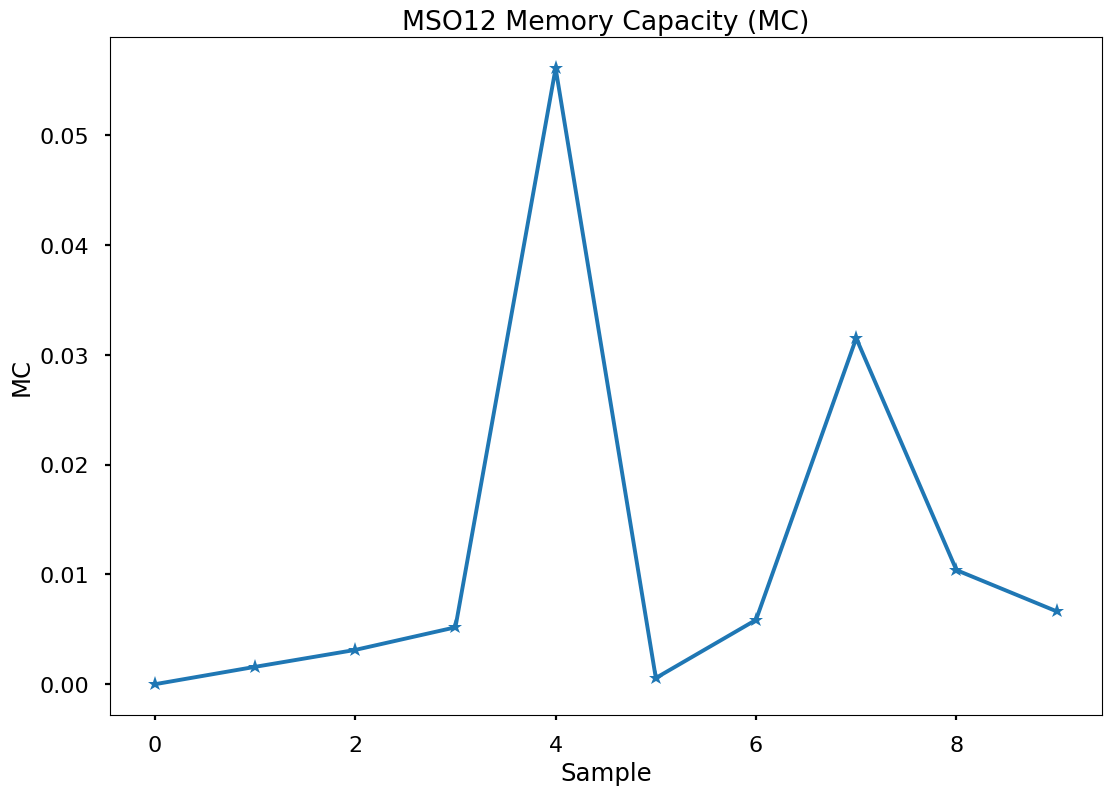

In [19]:
# Define the range of rho and L values to use
rhos = np.linspace(0.05, 3.5, 10)
Ls = np.linspace(0.5, 9, 10)

sparsity = 0.95

# Define the number of iterations to use
num_iterations = 1

# Initialize arrays to store the average MSE values
mse_values = np.zeros((len(rhos), len(Ls)))
r_values = np.zeros((len(rhos), len(Ls)))
mc_values = []

n = 1300
a = 100
b = 1200

N = 10

sparsity = 0.05

# Loop over all combinations of rho and L values
for i, rho in enumerate(rhos):
    for j, L in enumerate(Ls):
        
        # Initialize the mean squared error to zero
        mse = 0
        r = 0
        
        # Perform multiple iterations and average the results
        for k in range(num_iterations):

            print(i, j, k)
            
            # Initialize the input sequence and network parameters
            U = mso12(n)
            K = generate_K_matrix(N, rho, sparsity)
            W = generate_W_matrix(N)
            THETA = np.zeros((N, n))
            
            # Train the network and compute the mean squared error
            Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
            mse += MSE(U[b + 1:-1], Y[1:])
            r += kuramoto_synchrony(THETA[:, -1])
        
        mse /= num_iterations
        print('MSE:', mse)
        r /= num_iterations
        print('r:', r)

        # Store the mean squared error in the array
        mse_values[i, j] = mse
        r_values[i, j] = r
    
    mc = memory_capacity(Y)
    mc_values.append(mc)

# Create a contour plot of the average error as a function of rho and L
X, Y = np.meshgrid(rhos, Ls)
plt.imshow(mse_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MSO12 MSE vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

X, Y = np.meshgrid(rhos, Ls)
plt.imshow(r_values.T, extent=[np.min(rhos), np.max(rhos), np.min(Ls), np.max(Ls)], origin='lower', aspect='auto', interpolation='bilinear')
plt.xlabel(r'$\rho$')
plt.ylabel(r'$\lambda$')
plt.title(r'MSO12 $r$ vs. $\lambda$ vs. $\rho$')
plt.colorbar()
plt.show()

plt.plot(range(10), mc_values, '*-')
plt.xlabel('Sample')
plt.ylabel('MC')
plt.title('MSO12 Memory Capacity (MC)')
plt.show()

## Variación de la dispersión de la matriz $K$ para NARMA10

0 0
0.010099914512823948
0.19647166530774482
1 0
0.007802955854269991
0.20641221051679995
2 0
0.008047103990676027
0.254241780027343
3 0
0.009748729740126475
0.20952132522239791
4 0
0.008764740285756615
0.18157999489479476
5 0
0.008241348036707908
0.19449155608392246
6 0
0.007877193949190968
0.05830722153822789
7 0
0.007875096317592305
0.2804192961066548
8 0
0.009615546362413479
0.3500679450280092
9 0
0.00861475717120942
0.17543522955976587
10 0
0.00831889813881013
0.22153509529939966
11 0
0.009335071326877928
0.3287804741069697
12 0
0.008643347696680155
0.13411091156564053
13 0
0.009182175264997145
0.1569613976686997
14 0
0.009738986464380612
0.12579122084957536
15 0
0.008245008543134983
0.4606298318957047
16 0
0.009159938178821101
0.017552102145527722
17 0
0.010092786297596636
0.42404981644913786
18 0
0.008815264458355766
0.13317756671828396
19 0
0.007446476356748575
0.21219267210942097
20 0
0.008788463283900186
0.3089035625542921
21 0
0.009684537923503232
0.321665417454226
22 0
0.00

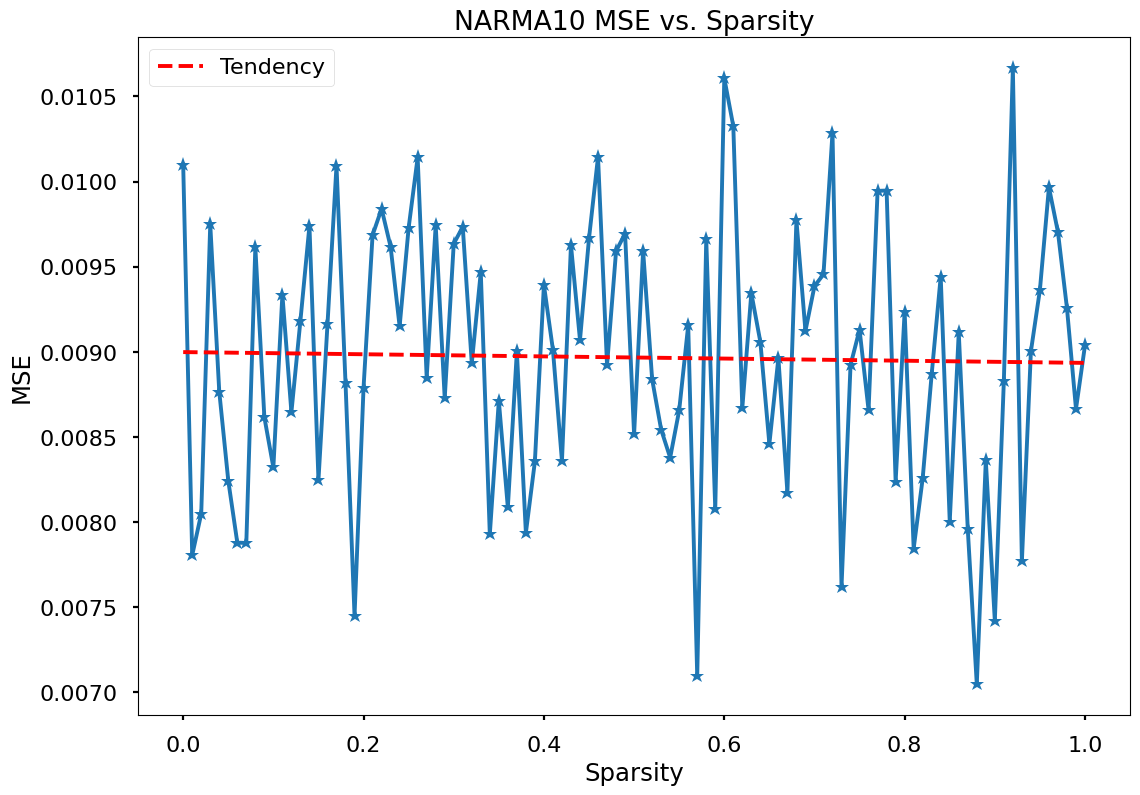

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
sparsity_values = np.arange(0, 1.01, 0.01)

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1400
a = 100
b = 900
N = 10

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(sparsity_values))
r_values = np.zeros(len(sparsity_values))

# Loop over sparsity values
for i, sparsity in enumerate(sparsity_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(num_iterations):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = narma10(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. sparsity
plt.plot(sparsity_values, mse_values, '*-')
plt.xlabel('Sparsity')
plt.ylabel('MSE')
plt.title('NARMA10 MSE vs. Sparsity')

# Fit a polynomial line (degree 1) to the data points
tendency = np.polyfit(sparsity_values, mse_values, 1)
tendency_line = np.poly1d(tendency)
plt.plot(sparsity_values, tendency_line(sparsity_values), '--', color='red', label='Tendency')

plt.legend()

plt.show()


## Variación de la dispersión de la matriz $K$ para MG17

0 0
0.0011217631309252455
0.3634784667211688
1 0
0.0011119892476774702
0.24503046002031084
2 0
0.0011111611088649674
0.27447507815941524
3 0
0.0010946719055122372
0.10499548153458511
4 0
0.0011209880507760922
0.47219761496702484
5 0
0.0011112079972143527
0.3309084577351402
6 0
0.001123297426073674
0.54423937693459
7 0
0.0010961669564224523
0.2860375093278346
8 0
0.0010955542315485337
0.08228707362695198
9 0
0.0011161273083970748
0.07938221460322688
10 0
0.0011095141869225192
0.2575519818873261
11 0
0.001119980724662606
0.31840342388611464
12 0
0.0010903770857432183
0.3132218290760273
13 0
0.0011138944375564698
0.1516361891052814
14 0
0.0011015340073453116
0.4829454178432004
15 0
0.0010982308337085466
0.07389878450411043
16 0
0.001089045489838167
0.19736817899392983
17 0
0.0010929971174754283
0.6509933583098874
18 0
0.0011218224258696854
0.31567234859292703
19 0
0.001114007119262122
0.08853893901671427
20 0
0.0011198375957464594
0.13624024195180887
21 0
0.0011061919757898817
0.273964073

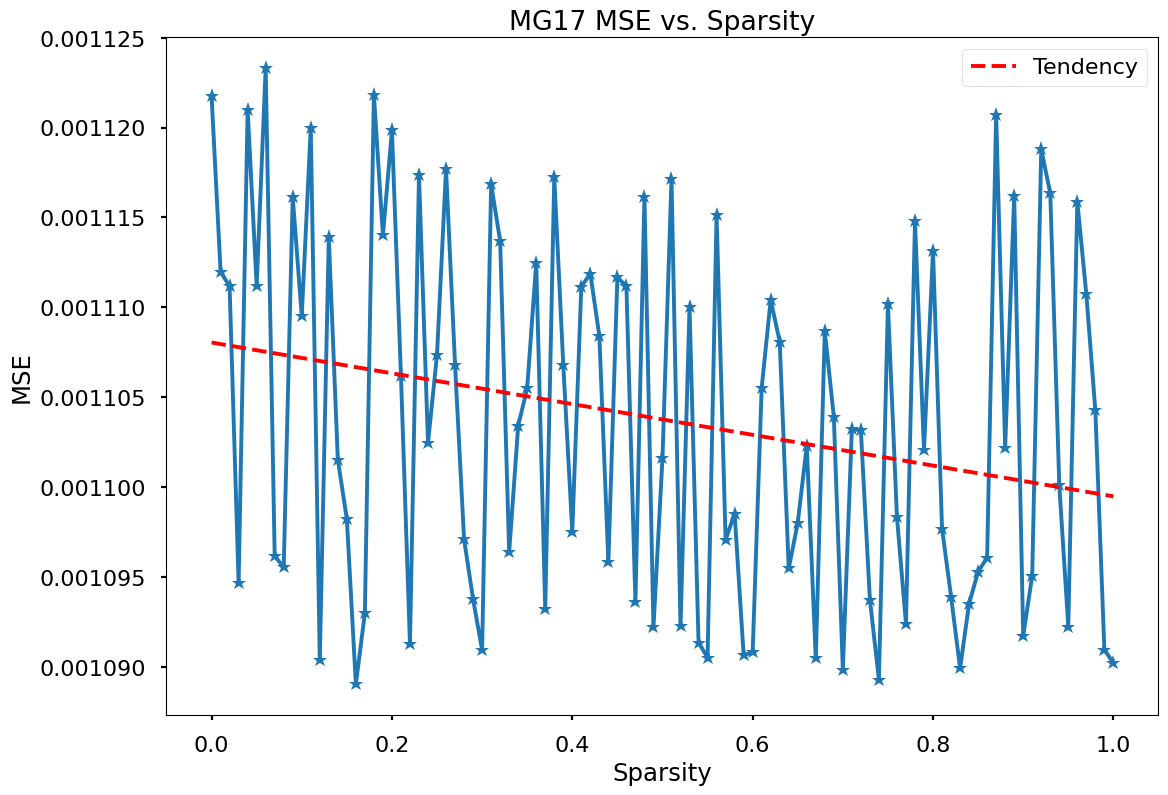

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
sparsity_values = np.arange(0, 1.01, 0.01)

# Set the fixed values for rho and L
rho = 2.0
L = 1.0

n = 3900
a = 100
b = 2900
N = 10

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(sparsity_values))
r_values = np.zeros(len(sparsity_values))

# Loop over sparsity values
for i, sparsity in enumerate(sparsity_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(num_iterations):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = MGSystem(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. sparsity
plt.plot(sparsity_values, mse_values, '*-')
plt.xlabel('Sparsity')
plt.ylabel('MSE')
plt.title('MG17 MSE vs. Sparsity')

# Fit a polynomial line (degree 1) to the data points
tendency = np.polyfit(sparsity_values, mse_values, 1)
tendency_line = np.poly1d(tendency)
plt.plot(sparsity_values, tendency_line(sparsity_values), '--', color='red', label='Tendency')

plt.legend()
plt.show()


## Variación de la dispersión de la matriz $K$ para MSO12

0 0


<ipython-input-2-86a2a31f90df>:16: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  y = np.sum(np.sin(2 * np.pi * frequencies[i] * t) for i in range(12))


3.0491688701794184e-06
0.09083733554774481
1 0
5.228501694731665e-06
0.09442130364514172
2 0
1.1120679414661696e-05
0.3403711461935773
3 0
3.4527366013942664e-06
0.08493923515518134
4 0
4.679795960409463e-06
0.5198138370713399
5 0
6.7963537643186075e-06
0.3409010960213815
6 0
9.513401680426444e-06
0.17264479657533213
7 0
1.089626974907074e-05
0.3265988997407753
8 0
4.104266098620521e-06
0.03287891957755242
9 0
1.695040950057751e-05
0.22345124317467624
10 0
6.2362625538684475e-06
0.10764041858114101
11 0
9.66088760447038e-06
0.5091503034483201
12 0
4.004087632321609e-06
0.08184693216701303
13 0
3.726494048707754e-06
0.0775855133702055
14 0
1.1519772966713601e-05
0.4476461559408449
15 0
4.886010339957107e-06
0.10446237827108701
16 0
9.162232546154325e-06
0.258171037410645
17 0
1.2237298523261878e-05
0.3542699961404364
18 0
4.912060532657327e-06
0.6276834294003237
19 0
3.675384327542803e-06
0.2955646735927492
20 0
5.596392591024136e-06
0.13107864743749953
21 0
3.98116948013255e-06
0.09208

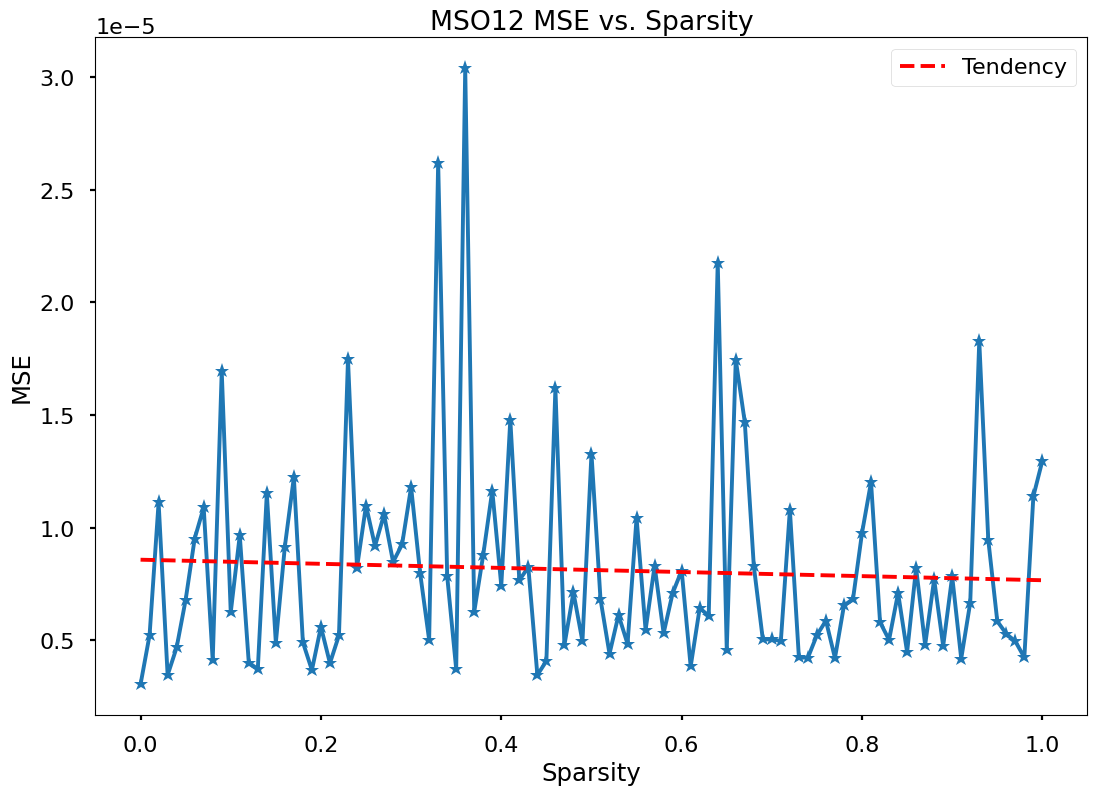

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
sparsity_values = np.arange(0, 1.01, 0.01)

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1300
a = 100
b = 1200
N = 10

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(sparsity_values))
r_values = np.zeros(len(sparsity_values))

# Loop over sparsity values
for i, sparsity in enumerate(sparsity_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(num_iterations):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = mso12(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:-1], Y[1:])
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. sparsity
plt.plot(sparsity_values, mse_values, '*-')
plt.xlabel('Sparsity')
plt.ylabel('MSE')
plt.title('MSO12 MSE vs. Sparsity')

# Fit a polynomial line (degree 1) to the data points
tendency = np.polyfit(sparsity_values, mse_values, 1)
tendency_line = np.poly1d(tendency)
plt.plot(sparsity_values, tendency_line(sparsity_values), '--', color='red', label='Tendency')

plt.legend()
plt.show()

## Variación de $\beta$ para NARMA10

0 0
0.00950985492574369
0.07644436431013833
1 0
0.008681478252578156
0.21157500303204715
2 0
0.009969030876809677
0.4912176771374322
3 0
0.007775539557297585
0.4697263409743507
4 0
0.009536334146643797
0.1658939898650461
5 0
0.008866266981115548
0.4298548178897184
6 0
0.006602132158307615
0.24246046888944484
7 0
0.009712603974765973
0.1820262655093306
8 0
0.008908674793492395
0.26581535027826925
9 0
0.008454719853062264
0.3459284980929437
10 0
0.008752438763037553
0.18779480481021288
11 0
0.008488489944879038
0.3863285866649913
12 0
0.010208872424998567
0.35056928106210716
13 0
0.009244313004064766
0.5456463422311176
14 0
0.009808209270622432
0.34997309656338627
15 0
0.007742900992372668
0.06074478801279008
16 0
0.007487647622547083
0.27186147515641335
17 0
0.008602974109465242
0.18635623517945935
18 0
0.00910928909189911
0.3085910372002767
19 0
0.008652744501917272
0.4255232758626761
20 0
0.009135290138433538
0.33356690624482216
21 0
0.009906349373914413
0.24122213366194334
22 0
0.009

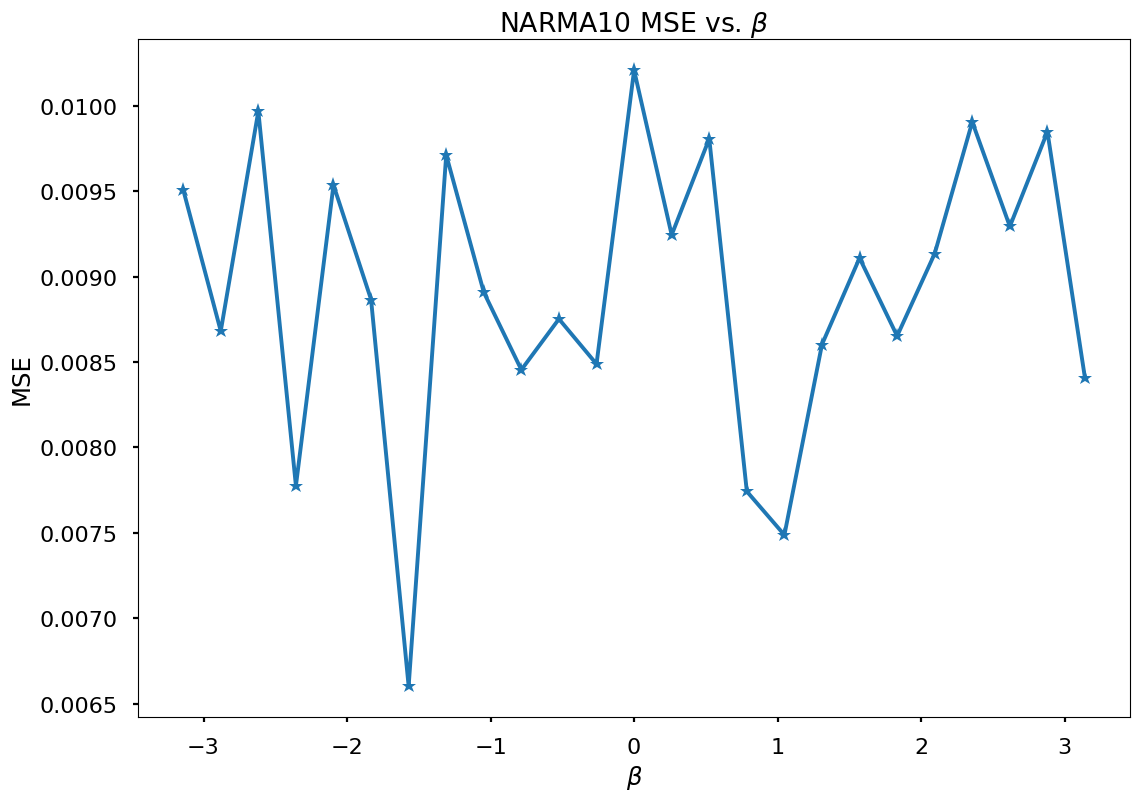

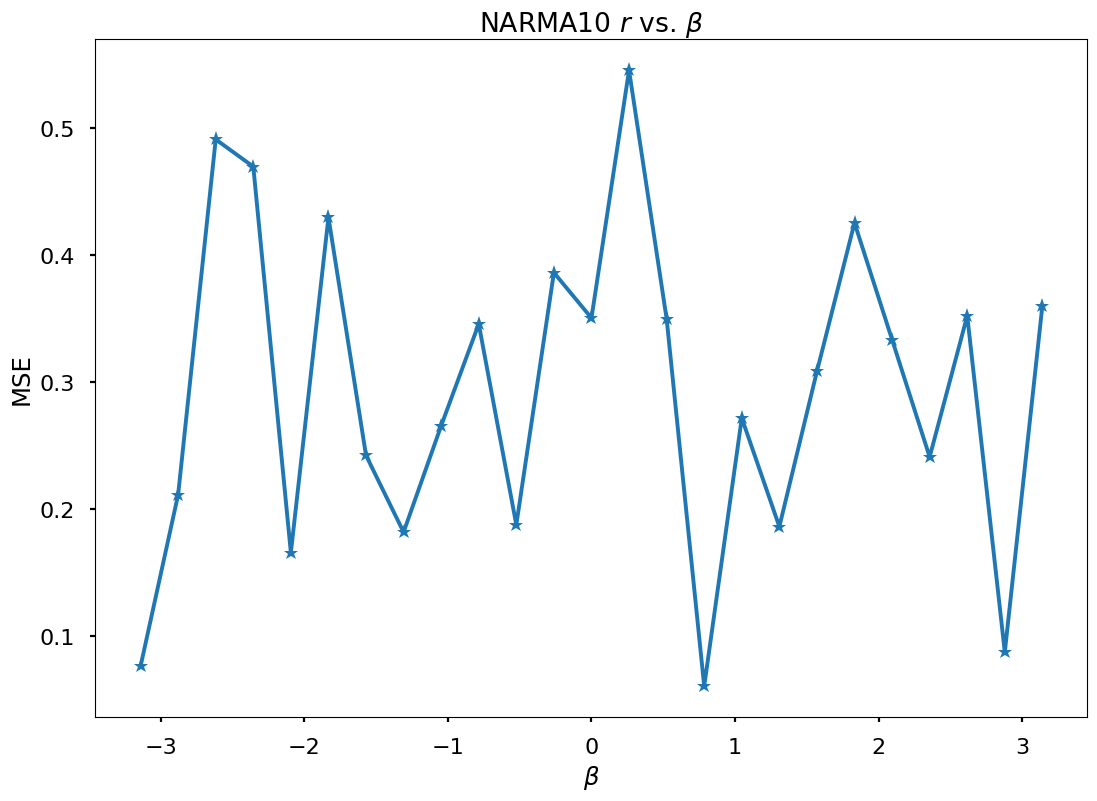

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
beta_values = np.arange(-np.pi, np.pi + np.pi/12, np.pi/12)

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1400
a = 100
b = 900
N = 10

sparsity = 0.95

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(beta_values))
r_values = np.zeros(len(beta_values))

# Loop over sparsity beta_values
for i, B in enumerate(beta_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(1):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = narma10(n)
        K = generate_K_matrix(N, rho, sparsity)
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)
        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r

# Plot MSE vs. beta
plt.plot(beta_values, mse_values, '*-')
plt.xlabel(r'$\beta$')
plt.ylabel('MSE')
plt.title(r'NARMA10 MSE vs. $\beta$')
plt.show()

plt.plot(beta_values, r_values, '*-')
plt.xlabel(r'$\beta$')
plt.ylabel('MSE')
plt.title(r'NARMA10 $r$ vs. $\beta$')
plt.show()


## Ejecución del algoritmo para NARMA10 para tres valores fijos de $\beta$

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range of sparsity values to use
beta_values = [-np.pi/2, 0, np.pi/2]

# Set the fixed values for rho and L
rho = 2.0
L = 4.0

n = 1400
a = 100
b = 900
N = 10

sparsity = 0.95

K_init = generate_K_matrix(N, rho, sparsity=sparsity)
developed_K_matrices = []

# Initialize arrays to store the average MSE and r values
mse_values = np.zeros(len(beta_values))
r_values = np.zeros(len(beta_values))

# Loop over sparsity beta_values
for i, B in enumerate(beta_values):
    # Initialize the mean squared error and r values
    mse = 0
    r = 0

    # Perform multiple iterations and average the results
    for k in range(1):
        print(i, k)

        # Initialize the input sequence and network parameters
        U = narma10(n)
        K = K_init.copy()
        THETA = np.zeros((N, n))
        W = generate_W_matrix(N)

        # Train the network and compute the mean squared error
        Y, THETA, K = train(U, K, rho, THETA, W, L, a, b, B)

        developed_K_matrices.append(K)

        mse += MSE(U[b + 1:], Y)
        r += kuramoto_synchrony(THETA[:, -1])

    mse /= num_iterations
    print(mse)
    r /= num_iterations
    print(r)

    # Store the mean squared error and r values
    mse_values[i] = mse
    r_values[i] = r


0 0
0.008448327889980886
0.10835604808392275
1 0
0.009241629740759861
0.4293133862713408
2 0
0.009013035539229641
0.2298887812328133


## Graficación del reservorio como una red de sinapsis inhibitorias y excitatorias

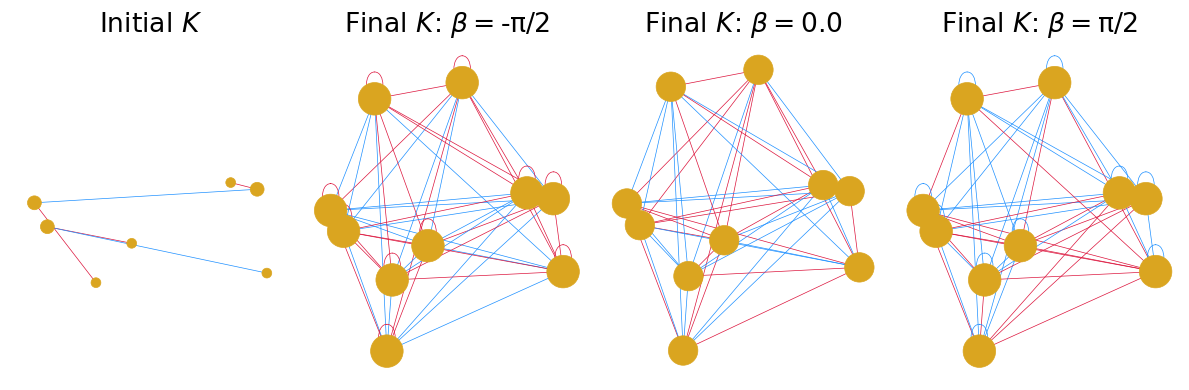

In [25]:
import networkx as nx

# Plotting the graphs
G_init = nx.from_numpy_array(K_init)

# Define a common layout for all graphs
pos = nx.spring_layout(G_init, seed=42)

plt.figure(figsize=(12, 4))
plt.subplot(1, len(developed_K_matrices) + 1, 1)
plt.title(r"Initial $K$")
edge_colors_init = ["crimson" if w > 0 else "dodgerblue" for u, v, w in G_init.edges.data("weight")]
nx.draw_networkx(G_init, pos=pos, node_size=50 * np.array(list(dict(G_init.degree()).values())), edge_color=edge_colors_init, width=0.5, with_labels=False, node_color='goldenrod')
plt.axis("off")

for i, K in enumerate(developed_K_matrices):
    G = nx.from_numpy_array(K)

    plt.subplot(1, len(developed_K_matrices) + 1, i + 2)
    plt.title(r"Final $K$: $\beta=$" + ['-π/2', '0.0', 'π/2'][i])
    edge_colors = ["crimson" if w > 0 else "dodgerblue" for u, v, w in G.edges.data("weight")]
    nx.draw_networkx(G, pos=pos, node_size=50 * np.array(list(dict(G.degree()).values())), edge_color=edge_colors, width=0.5, with_labels=False, node_color='goldenrod')
    plt.axis("off")

plt.tight_layout()
plt.show()
